In [20]:
import os
import cv2, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from google.colab import drive
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, RMSprop, Adagrad
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [2]:
drive.mount('./mount')#執行後點擊連結，複製金鑰
os.environ['KAGGLE_CONFIG_DIR'] = '/content/mount/My Drive/Colab Notebooks/kaggle' #注意kaggle資料夾包含json檔案

Mounted at ./mount


In [ ]:
!kaggle competitions download -c 2021-ml-100-marathon-final-exam
!unzip 2021-ml-100-marathon-final-exam.zip

In [38]:
x = []
y = []
flower_mapping = {'daisy':0, 'dandelion':1, 'rose':2, 'sunflower':3, 'tulip':4}
for folder in glob.glob('/content/image_data/train/*') :
    print(folder,'讀取')
    label = folder.split('/')[-1]
    for f in os.listdir(folder):
        try:
            img = cv2.imread(os.path.join(folder, f))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, dsize=(224,224))
            if img is not None:
                x.append(img)
                y.append(flower_mapping[label])
        except:
            pass
print('完成')

/content/image_data/train/sunflower 讀取
/content/image_data/train/daisy 讀取
/content/image_data/train/dandelion 讀取
/content/image_data/train/rose 讀取
/content/image_data/train/tulip 讀取
完成


In [ ]:
# data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
# image = Image.open(os.path.join(folder, f))
# size = (224, 224)
# image = ImageOps.fit(image, size, Image.ANTIALIAS)
# image_array = np.asarray(image)
# normalized_image_array = image_array.astype(np.float32) / 255.0
# data[0] = normalized_image_array

In [39]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = np.array(x_train)
x_valid = np.array(x_valid)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

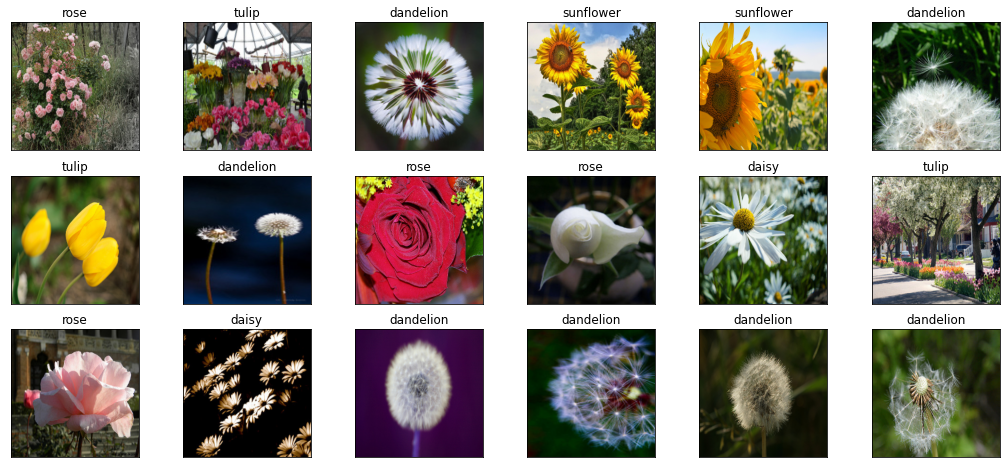

In [40]:
# flower_name = {0:'雏菊', 1:'蒲公英', 2:'玫瑰', 3:'向日葵', 4:'鬱金香'}
flower_name = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
func = lambda i: flower_name[i]
start = 88
plt.figure(figsize = (18, 8)) 
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.imshow(x_train[start+i])
    plt.xticks([]), plt.yticks([])
    plt.title(flower_name[y_train[start+i]])
plt.show()

In [42]:
x_train = x_train.astype('float32') / 255.0
x_valid = x_valid.astype('float32') / 255.0

y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)

In [43]:
# 遷移學習
resnet_model = ResNet50(input_shape=(224,224,3),
                       weights='imagenet',
                       pooling='avg',
                       include_top=False)

x = resnet_model.output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(5, activation='softmax')(x)
model = Model(inputs = resnet_model.input, outputs = output)

for layer in model.layers[:2]:
    layer.trainable = False
for layer in model.layers[2:]:
    layer.trainable = True

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
batch_size = 4
epochs = 60
lr=1e-4

train_generator = ImageDataGenerator(rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)
train_gen = train_generator.flow(x_train, y_train, batch_size)

valid_generator = ImageDataGenerator()
valid_gen = valid_generator.flow(x_valid, y_valid, batch_size)

model_ckpt = ModelCheckpoint(filepath="model.h5", 
                             monitor="val_loss", 
                             save_best_only=True)

reduce_lr = ReduceLROnPlateau(factor=0.2, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=4, 
                              verbose=1)

model.compile(optimizer=Adam(learning_rate=lr),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.fit_generator(train_gen,
                    steps_per_epoch=len(x_train)//batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=valid_gen,
                    validation_steps=len(x_valid)//batch_size,
                    callbacks=[model_ckpt, reduce_lr])

# model.fit(x_train, y_train, 
#           epochs=epochs, 
#           batch_size=batch_size, 
#           validation_data=(x_valid, y_valid), 
#           shuffle=True,
#           callbacks=[model_ckpt, reduce_lr]
#          )

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


564/564 [==============================] - 53s 84ms/step - loss: 1.0580 - accuracy: 0.6748 - val_loss: 1.1338 - val_accuracy: 0.7553 - lr: 1.0000e-04
Epoch 2/60
564/564 [==============================] - 43s 76ms/step - loss: 0.9330 - accuracy: 0.7059 - val_loss: 3.4159 - val_accuracy: 0.6436 - lr: 1.0000e-04
Epoch 3/60
564/564 [==============================] - 43s 76ms/step - loss: 0.8697 - accuracy: 0.7174 - val_loss: 3.0692 - val_accuracy: 0.7340 - lr: 1.0000e-04
Epoch 4/60
564/564 [==============================] - 44s 79ms/step - loss: 0.8286 - accuracy: 0.7360 - val_loss: 15.1525 - val_accuracy: 0.5904 - lr: 1.0000e-04
Epoch 5/60
564/564 [==============================] - ETA: 0s - loss: 0.8155 - accuracy: 0.7493
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
564/564 [==============================] - 43s 76ms/step - loss: 0.8155 - accuracy: 0.7493 - val_loss: 2.7012 - val_accuracy: 0.7535 - lr: 1.0000e-04
Epoch 6/60
564/564 [=======================

In [ ]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

show_train_history(model.history,'accuracy','val_accuracy')
show_train_history(model.history,'loss','val_loss')

18/18 [==============================] - 4s 129ms/step - loss: 0.2883 - accuracy: 0.9204
模型正確率為： 0.9203540086746216
辨識結果為： rose


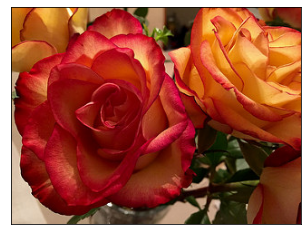

In [15]:
model_callback = load_model("model.h5")
print('模型正確率為：', model_callback.evaluate(x_valid, y_valid)[1])

img_path = '/content/image_data/test/034d01c095f88f0bcde09c3bb96682cd.jpg'
# img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.xticks([]), plt.yticks([])
# img = cv2.resize(img, dsize=(224, 224))
# img = np.expand_dims(img, axis=0)
# img = preprocess_input(img)
# pred = model.predict(img)
# print('辨識結果為：', func(np.argmax(pred)))


data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
image = Image.open(img_path)
plt.imshow(image)
plt.xticks([]), plt.yticks([])
size = (224, 224)
image = ImageOps.fit(image, size, Image.ANTIALIAS)
image_array = np.asarray(image)
normalized_image_array = image_array.astype(np.float32) / 255.0
data[0] = normalized_image_array
pred = model_callback.predict(data)
print('辨識結果為：', flower_name[np.argmax(pred)])

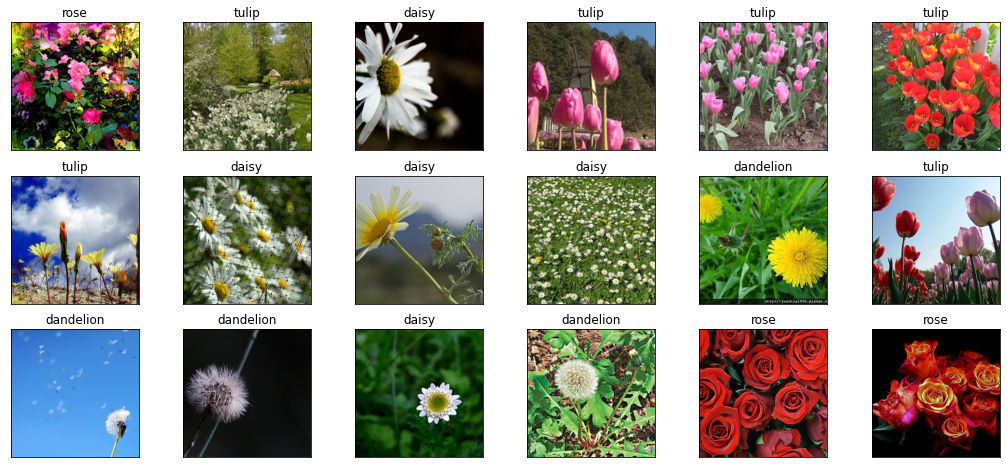

In [16]:
i = 1
test_folder = '/content/image_data/test/'
plt.figure(figsize = (18, 8)) 
for f in os.listdir(test_folder):
    plt.subplot(3, 6, i)
    # img = cv2.imread(test_folder+f)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.resize(img, dsize=(224,224))
    # plt.imshow(img)
    # plt.xticks([]), plt.yticks([])
    # img = np.expand_dims(img, axis=0)
    # img = preprocess_input(img)
    # pred = model_callback.predict(img)
    data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
    image = Image.open(test_folder+f)
    size = (224, 224)
    image = ImageOps.fit(image, size, Image.ANTIALIAS)
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])
    image_array = np.asarray(image)
    normalized_image_array = image_array.astype(np.float32) / 255.0
    data[0] = normalized_image_array
    pred = model_callback.predict(data)
    plt.title(flower_name[np.argmax(pred)])
    i+=1
    if i>18:
        break

In [17]:
idx = []
cls = []
for f in os.listdir(test_folder):
    id = f.split('.')[0]
    # img = cv2.imread(test_folder+f)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.resize(img, dsize=(224,224))
    # img = np.expand_dims(img, axis=0)
    # img = preprocess_input(img)
    # pred = model_callback.predict(img)
    data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
    image = Image.open(test_folder+f)
    size = (224, 224)
    image = ImageOps.fit(image, size, Image.ANTIALIAS)
    image_array = np.asarray(image)
    normalized_image_array = image_array.astype(np.float32) / 255.0
    data[0] = normalized_image_array
    pred = model_callback.predict(data)
    idx.append(id)
    cls.append(np.argmax(pred))
print('完成')

完成


In [19]:
df = pd.DataFrame({'id':idx, 'flower_class':cls})
df.to_csv('myflower_submission.csv', index=None)